In [60]:
#@title import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import numpy as np
import random
import torch.nn.functional as F
from copy import deepcopy

# Set seeds for reproducibility
SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Machine Unlearning on a MNIST classifier - BASELINE test

## Setup

In [2]:
#@title define the neural network

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NN()

In [89]:
#@title loading and preprocessing data

# Define transformations for the training and validation data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Initial Training
To begin, we'll train a neural network to classify the MNIST dataset. This section covers the steps from setting up environment to evaluating the model's accuracy. If you prefer, you can skip this section and use the pre-trained model from the GitHub repository (instructions for downloading are in the next section).

In [4]:
#@title define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
#@title train the network

n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f' Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

 10%|█         | 1/10 [00:19<02:56, 19.57s/it]

 Epoch 1, Loss: 1.0238848064881143


 20%|██        | 2/10 [00:39<02:39, 19.97s/it]

 Epoch 2, Loss: 0.38597884826632195


 30%|███       | 3/10 [01:06<02:42, 23.22s/it]

 Epoch 3, Loss: 0.3257994085613853


 40%|████      | 4/10 [01:45<02:55, 29.19s/it]

 Epoch 4, Loss: 0.29247956143926457


 50%|█████     | 5/10 [02:05<02:10, 26.00s/it]

 Epoch 5, Loss: 0.2666079622230677


 60%|██████    | 6/10 [02:25<01:35, 23.90s/it]

 Epoch 6, Loss: 0.24376501867781952


 70%|███████   | 7/10 [02:45<01:08, 22.75s/it]

 Epoch 7, Loss: 0.2241767061266627


 80%|████████  | 8/10 [03:07<00:44, 22.48s/it]

 Epoch 8, Loss: 0.20669279496139809


 90%|█████████ | 9/10 [03:26<00:21, 21.48s/it]

 Epoch 9, Loss: 0.19195180559066186


100%|██████████| 10/10 [03:48<00:00, 22.85s/it]

 Epoch 10, Loss: 0.17762162606678664


In [6]:
#@title evaluate the network

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 94.9%


In [9]:
#@title save the model
joblib.dump(model, "MNIST_Classifier.joblib")

['MNIST_Classifier.joblib']

## Unlearning

In [ ]:
#@title download the pre-trained model from GitHub (if you skipped the previous section)
!wget -O MNIST_Classifier.joblib 'https://github.com/mich1803/Yesterday-Machine-Unlearning/raw/main/saved%20models/MNIST/MNIST_Classifier.joblib'
model = joblib.load('MNIST_Classifier.joblib')

### Identify the parameters (weights and biases) most involved in the prediction of a specific class.

In [74]:
unlearning_loader = DataLoader(trainset, batch_size=1000, shuffle=True)
for x, y in unlearning_loader:
  images, labels = x, y
  break

In [77]:
# Set model to evaluation mode
model.eval()
# Filter only class 6 samples
mask = labels == 6
class_6_images = images[mask]
class_6_labels = labels[mask]

# Forward pass
outputs = model(class_6_images)
loss = nn.CrossEntropyLoss()(outputs, class_6_labels)

# Compute gradients
model.zero_grad()
loss.backward()

# Collect gradients
gradients = []
for name, param in model.named_parameters():
    if param.requires_grad:
        gradients.append((name, param.grad.abs().sum().item(), param.grad))

# Sort gradients by absolute value
sorted_gradients = sorted(gradients, key=lambda x: x[1], reverse=True)

# Get the names and gradients of the top 250 parameters
top_250_params = sorted_gradients[:250]

### Fine-Tuning

#### LOSS: Changing the original labels

In [78]:
model1 = deepcopy(model)

# Freeze all parameters
for param in model1.parameters():
    param.requires_grad = False

# Unfreeze the top 250 parameters
for name, _, grad in top_250_params:
    for name_, param in model1.named_parameters():
        if name_ == name:
            param.requires_grad = True

# Set up the optimizer to update only the top 250 parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=1e-4)

In [79]:
# Define a custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, labels):
        # Create a modified version of labels where 6 is replaced by 3
        modified_labels = torch.where(labels == 6, 3, labels)
        loss = self.cross_entropy(outputs, modified_labels)
        return loss

criterion = CustomLoss()

In [91]:
# Fine-tune the network
model1.train()

n_epochs = 2
for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc = f"epoch: {epoch + 1}. "):
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


epoch: 1. : 100%|██████████| 938/938 [00:24<00:00, 38.92it/s]


Fine-tuning Epoch 1, Loss: 0.17502441737792893


epoch: 2. : 100%|██████████| 938/938 [00:25<00:00, 36.43it/s]

Fine-tuning Epoch 2, Loss: 0.14975910177077056


##### Unlearning Validation

In [92]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set after fine-tuning: {100 * correct / total}%')


Accuracy on the test set after fine-tuning: 86.49%


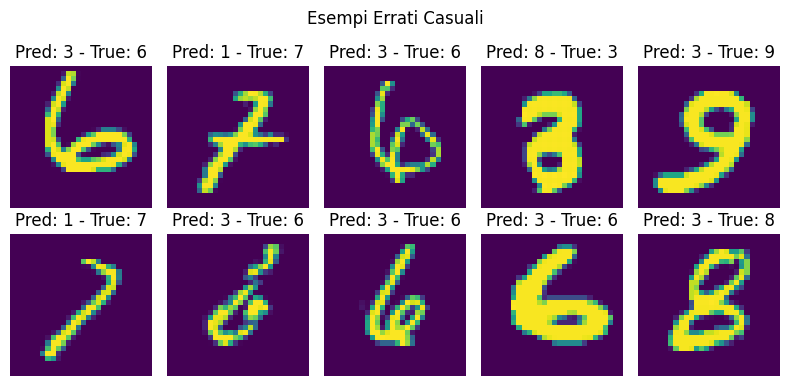

In [93]:
misclassified_images = []
misclassified_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        # Trova gli indici degli errori
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(predicted[idx].cpu())
            true_labels.append(labels[idx].cpu())

num_samples = min(10, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), num_samples, replace=False)

# Impostare la griglia 5x5
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Esempi Errati Casuali')

# Iterare sugli indici selezionati per visualizzare le immagini
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = misclassified_images[idx]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'Pred: {misclassified_labels[idx].item()} - True: {true_labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [94]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels == 6
        if mask.sum() == 0:
            continue #if there are no 6, skip this batch

        images_6 = images[mask]
        labels_6 = labels[mask]
        outputs = model1(images_6)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_6.size(0)
        correct += (predicted == labels_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on immagini with label 6: {accuracy:.2f}%')


Accuracy on immagini with label 6: 0.00%


In [95]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels != 6
        if mask.sum() == 0:
            continue

        images_not_6 = images[mask]
        labels_not_6 = labels[mask]

        outputs = model(images_not_6)
        _, predicted = torch.max(outputs.data, 1)

        total += labels_not_6.size(0)
        correct += (predicted == labels_not_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with other labels (not 6): {accuracy:.2f}%')


Accuracy on images with other labels (not 6): 94.63%


In [187]:
joblib.dump(model1, "MNIST_Classifier_unl6_labels.joblib")

['MNIST_Classifier_unl6_labels.joblib']

#### LOSS: Penalyzing the 6

In [177]:
model2 = deepcopy(model)

# Freeze all parameters
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the top 250 parameters
for name, _, grad in top_250_params:
    for name_, param in model2.named_parameters():
        if name_ == name:
            param.requires_grad = True

# Set up the optimizer to update only the top 250 parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)

In [179]:
class CustomLoss(nn.Module):
    def __init__(self, tau=1e5):
        super(CustomLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.tau = tau

    def forward(self, outputs, labels):
        # Standard cross-entropy loss
        original_loss = self.cross_entropy(outputs, labels)

        # Penalize the model if it predicts class 6
        class_6_logits = outputs[:, 6]  # Logits for class 6

        # Apply sigmoid to scale logits to [0, 1]
        scaled_logits = torch.sigmoid(class_6_logits)

        # Apply penalty directly on the scaled logits
        penalty_6 = self.tau * torch.mean(scaled_logits)

        # Total loss
        loss = original_loss + penalty_6
        return loss

criterion = CustomLoss()

In [180]:
# Fine-tune the network
model2.train()

n_epochs = 2
for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc = f"epoch: {epoch + 1}. "):
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


epoch: 1. : 100%|██████████| 938/938 [00:24<00:00, 37.89it/s]


Fine-tuning Epoch 1, Loss: 364.2573686852765


epoch: 2. : 100%|██████████| 938/938 [00:24<00:00, 37.87it/s]

Fine-tuning Epoch 2, Loss: 2.1251558704035625


##### Unlearning Validation

In [181]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set after fine-tuning: {100 * correct / total}%')


Accuracy on the test set after fine-tuning: 83.12%


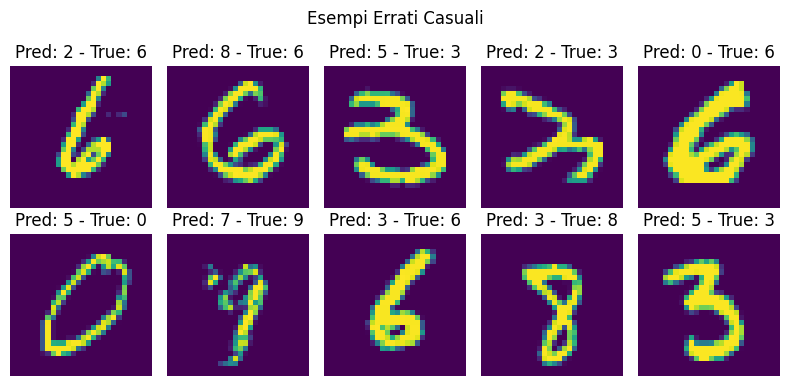

In [182]:
misclassified_images = []
misclassified_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        # Trova gli indici degli errori
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(predicted[idx].cpu())
            true_labels.append(labels[idx].cpu())

num_samples = min(10, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), num_samples, replace=False)

# Impostare la griglia 5x5
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Esempi Errati Casuali')

# Iterare sugli indici selezionati per visualizzare le immagini
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = misclassified_images[idx]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'Pred: {misclassified_labels[idx].item()} - True: {true_labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [183]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels == 6
        if mask.sum() == 0:
            continue #if there are no 6, skip this batch

        images_6 = images[mask]
        labels_6 = labels[mask]
        outputs = model2(images_6)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_6.size(0)
        correct += (predicted == labels_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on immagini with label 6: {accuracy:.2f}%')


Accuracy on immagini with label 6: 0.00%


In [184]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels != 6
        if mask.sum() == 0:
            continue

        images_not_6 = images[mask]
        labels_not_6 = labels[mask]

        outputs = model2(images_not_6)
        _, predicted = torch.max(outputs.data, 1)

        total += labels_not_6.size(0)
        correct += (predicted == labels_not_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with other labels (not 6): {accuracy:.2f}%')


Accuracy on images with other labels (not 6): 91.93%


In [189]:
joblib.dump(model2, "MNIST_Classifier_unl6_penalty.joblib")

['MNIST_Classifier_unl6_penalty.joblib']